In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd 

In [3]:
df = pd.read_csv(r"../../Dataset/NCA Preprocessed/master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [ ]:
# -------------------------
# 1. One-hot encode temp & charge-rate
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 2. Drop useless columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 3. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Target
Y = df_dropped['SOH'].values

# Features before splitting
X_ic_all = df_dropped[ic_cols].values                # shape: (N, 20)
X_cycle_all = df_dropped[[cycle_col]].values         # shape: (N, 1)
X_onehot_all = df_dropped[one_hot_cols].values       # shape: (N, 6)

# -------------------------
# 4. Train/test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_cat_train, X_cat_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 5. Scale IC features
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 6. Scale cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 7. Build final CONTEXT vector (cycle + one-hot)
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_cat_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_cat_test], axis=1)

# -------------------------
# 8. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# -------------------------
# 9. Reshape IC features for CNN+LSTM (20 timesteps, 1 feature)
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)   # shape: (N, 20, 1)
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

print("IC input:", X_ic_train.shape)
print("Context input:", X_context_train.shape)
print("Target:", y_train.shape)
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("Y:", y_train.shape)

NameError: name 'df' is not defined

In [4]:
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# ---------------------------------------------------
# 1. Drop unused columns
# ---------------------------------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# ---------------------------------------------------
# 2. Identify columns
# ---------------------------------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Raw arrays
X_ic_all = df_dropped[ic_cols].values
X_cycle_all = df_dropped[[cycle_col]].values
X_onehot_all = df_dropped[one_hot_cols].values
Y = df_dropped['SOH'].values

mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Removed NaN/Inf rows:", np.sum(~mask_clean))

X_ic_all = X_ic_all[mask_clean]
X_cycle_all = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y = Y[mask_clean]

IC_OUTLIER_THRESHOLD_HIGH = 20

mask_outlier = np.all((np.abs(X_ic_all) < IC_OUTLIER_THRESHOLD_HIGH), axis=1)

print("IC outlier rows removed:", np.sum(~mask_outlier))

# Apply mask
X_ic_all = X_ic_all[mask_outlier]
X_cycle_all = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y = Y[mask_outlier]


bad_index_1 = 3439
bad_index_2 = 64
negative_mask = ((np.arange(len(X_ic_all)) != bad_index_1) & (np.arange(len(X_ic_all)) != bad_index_2))

X_ic_all = X_ic_all[negative_mask]
X_cycle_all = X_cycle_all[negative_mask]
X_onehot_all = X_onehot_all[negative_mask]
Y = Y[negative_mask]


Removed NaN/Inf rows: 3
IC outlier rows removed: 2


In [24]:
# -------------------------
# 1. One-hot encode temp & charge-rate
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 2. Drop useless columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 3. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Target
Y = df_dropped['SOH'].values

# Features before splitting
X_ic_all = df_dropped[ic_cols].values                # shape: (N, 20)
X_cycle_all = df_dropped[[cycle_col]].values         # shape: (N, 1)
X_onehot_all = df_dropped[one_hot_cols].values       # shape: (N, 6)


print(X_ic_all.shape)
print(X_cycle_all.shape)
print(X_onehot_all.shape)

mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Removed NaN/Inf rows:", np.sum(~mask_clean))

X_ic_all = X_ic_all[mask_clean]
X_cycle_all = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y = Y[mask_clean]


print(X_ic_all.shape)
print(X_cycle_all.shape)
print(X_onehot_all.shape)

IC_OUTLIER_THRESHOLD_HIGH = 20

mask_outlier = np.all((np.abs(X_ic_all) < IC_OUTLIER_THRESHOLD_HIGH), axis=1)

print("IC outlier rows removed:", np.sum(~mask_outlier))

# Apply mask
X_ic_all = X_ic_all[mask_outlier]
X_cycle_all = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y = Y[mask_outlier]


print(X_ic_all.shape)
print(X_cycle_all.shape)
print(X_onehot_all.shape)

bad_index_1 = 3439
bad_index_2 = 64
negative_mask = ((np.arange(len(X_ic_all)) != bad_index_1) & (np.arange(len(X_ic_all)) != bad_index_2))

X_ic_all = X_ic_all[negative_mask]
X_cycle_all = X_cycle_all[negative_mask]
X_onehot_all = X_onehot_all[negative_mask]
Y = Y[negative_mask]

print(X_ic_all.shape)
print(X_cycle_all.shape)
print(X_onehot_all.shape)



(22644, 20)
(22644, 1)
(22644, 6)
Removed NaN/Inf rows: 3
(22641, 20)
(22641, 1)
(22641, 6)
IC outlier rows removed: 2
(22639, 20)
(22639, 1)
(22639, 6)
(22637, 20)
(22637, 1)
(22637, 6)


In [25]:
print("IC values range", X_ic_all.min(), X_ic_all.max())

IC values range 0.4988007619513083 6.440837130027602


In [22]:
type(X_ic_all)

numpy.ndarray

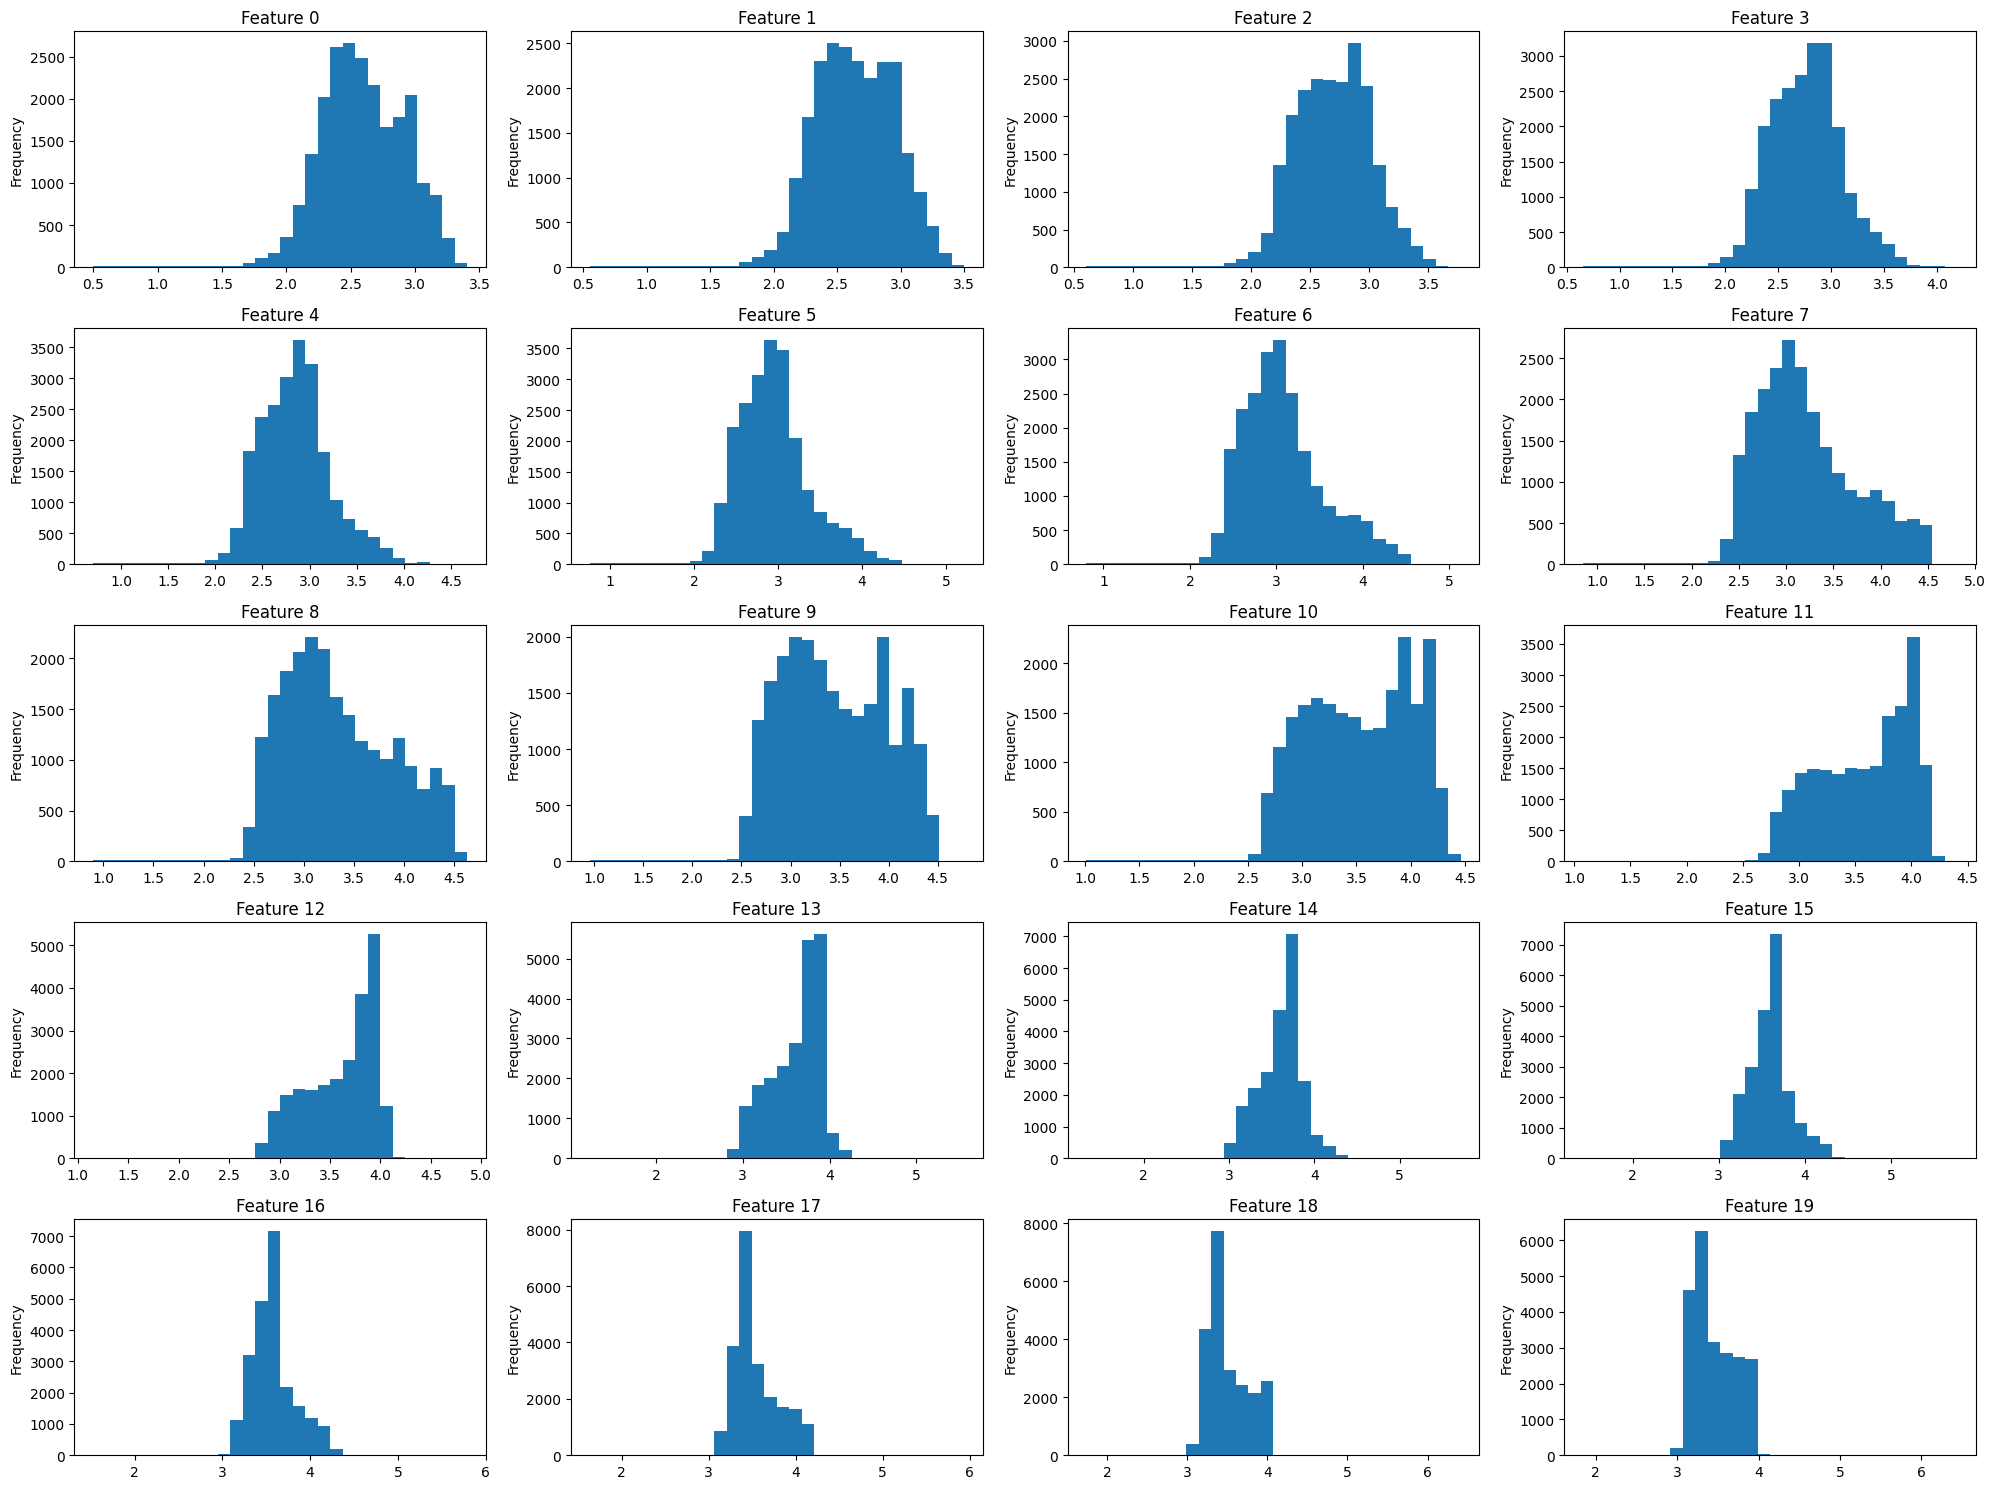

In [26]:
import matplotlib.pyplot as plt
import numpy as np

n_cols = 4
n_features = X_ic_all.shape[1]
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()

for i in range(n_features):
    axes[i].hist(X_ic_all[:, i], bins=30)
    axes[i].set_title(f"Feature {i}")
    axes[i].set_ylabel("Frequency")

# remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
